## PCS5024 - Aprendizado Estatístico
 - Primeiro trimestre 2023 
 - Profs. Anna Helena Realli Costa e Fábio Gagliardi Cozman 
 - Aluno: Caio Azevedo - caio.aze@alumni.usp.br
 - Entrega em: 30.03.23

## Trabalho 1 - Descrição
A entregar até 31/3 via edisciplinas: uma folha apenas (frente e verso) em formato pdf, contendo descrição concisa relativa às seguintes atividades:

1) Obtenha a base Adult (por exemplo no UCI Repository or no Kaggle). 

Recomendação: leia sobre o UCI Repository e o Kaggle, são recursos importantes.

2) Analise os atributos, dados faltantes, e características gerais da base Adult, usando ferramentas da sklearn. Selecione atributos, discretize atributos numéricos, processe dados faltantes. Se possível use Jupyter para desenvolver seu trabalho.

3) Construa um classificador para a variável ">50k" da base Adult (ou seja, se a pessoa ganha mais do que US$50k por ano ou não). Use um classificador Nearest Neighbour com seleção de hiperparâmetro via validação cruzada; se preferir, divida a base de treino em duas partes respectivamente para treino e validação. 

5) Apresente acurácia, precisão e revocação do melhor classificador Nearest Neighbour obtido.

6) Ponto extra: teste um classificador Naive Bayes para a mesma variável com os mesmos atributos.

## Objetivo
 - Análise para classificação das pessoas que ganham mais de U$50k por ano. 
 - **Projeto Classificação Binária**

## Sobre o dataset

### Características descritivas
| Data Set Characteristics | Number of Instances | Attribute Characteristics | Number of Attributes | Associated Tasks | Missing Values? 
| --- | --- | --- | --- | --- | --- 
| Multivariate | 48842 | Categorical, Integer | 14 | Classification | Yes 

### Sobre os atributos

- **salary** (target): >50K, <=50K.

- **age**: continuous.
- **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked.
- **fnlwgt**: continuous.
- **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, - -  - Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool.
- **education-num**: continuous.
- **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
- **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
- **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
- **race**: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black.
- **sex**: Female, Male.
- **capital-gain**: continuous.
- **capital-loss**: continuous.
- **hours-per-week**: continuous.
- **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

## Referências:
 - https://archive.ics.uci.edu/ml/datasets/adult
 - https://archive.ics.uci.edu/ml/machine-learning-databases/adult/
 - http://www.cs.toronto.edu/~delve/data/adult/adultDetail.html
 - http://www.cs.toronto.edu/~delve/data/adult/desc.html
 - https://www.scaler.com/topics/data-science/categorical-missing-values/ 
 
 
 **Sobre balanceamento e classificação**
 - https://machinelearningmastery.com/imbalanced-classification-with-the-adult-income-dataset/
 - https://medium.com/analytics-vidhya/handle-missing-values-in-categorical-features-b7c5b073dda2

 boas implementações
 - https://www.kaggle.com/code/bhupendrarajput/complete-eda-and-machine-learning
 - https://arxiv.org/ftp/arxiv/papers/1810/1810.10076.pdf
 - https://github.com/itdxer/adult-dataset-analysis

## Implementação

### Importação bibliotecas

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport

In [3]:
import os, sys
import pandas as pd
from sklearn.model_selection import train_test_split
import missingno as msno
from sklearn.impute import SimpleImputer
%matplotlib inline

### Constantes

In [4]:
#'https://raw.githubusercontent.com/Bhupendra1770/Adult-Census-Income-Prediction/main/adult.csv'
APP_PATH = os.getcwd()
DATA_DIR = os.path.join(APP_PATH, 'data')
TRAIN_DATA_FILE = os.path.join(DATA_DIR, 'adult.data.csv')
TEST_DATA_FILE = os.path.join(DATA_DIR, 'adult.test.csv')
target_column = "income"

### Considerações para implementação do classsificador

- O atributo fnlwgt será removido para implementação da classificação, seja porque sua definição não agrega valor à predição, seja pela análise estatística que provou sua baixa correlação ao atributo target.
- O atributo education-num também será removido pois seu valor já está representado com o atributo education
- O atributo native-country será transformado em um atributo binário chamado fromUS, cujo valor será 1 quando native_country for igual a United-States e 0 caso contrário.
- Os atributos capital-gain e capital-loss, também são candidatos a exclusão pois concentram seu dominio em um único valor (zero)
- Registros duplicados e impossíveis de classificar também devem ser removidos da amostra de treino.
- Deve-se testar pelo menos duas abordagens para tratamento dos registros com NaN e utilizar o de melhor desempenho do classificador.
- O atributo target deve ser tratado e seu valor convertido em 1 ou 0


### Leitura e tratamento das amostras

In [5]:
def read_dataset(path):
    return pd.read_csv(
        path,
        index_col=None,
        comment='|',  
        skipinitialspace=True,  
        na_values={
            'capital-gain': 99999,
            'workclass': '?',
            'native-country': '?',
            'occupation': '?',
        },
    )

def clean_dataset(data):

    #remove eventuais espaços vazios no inicio e/ou fim das colunas do tipo string 'object'
    for i in data.columns:
        if data[i].dtype=='object':
            data[i] = data[i].str.strip()

    # Por algum motivo o dataset de teste tem um ponto (.) no final do atributo target, sendo necessário remove-lo
    data[target_column] = data.income.str.rstrip('.')
    
    # Remoção das colunas colunas abaixo, pois entendemos que elas não são 
    # relevantes para classificação.
    data = data.drop('fnlwgt', axis=1)
    data = data.drop('education-num', axis=1)
    data = data.drop('capital-gain', axis=1)
    data = data.drop('capital-loss', axis=1)
    
    # Registros duplicados podem gerar viés na analise e classificação, 
    # logo devem ser removidos
    data = data.drop_duplicates()
    
    # "Binariza" o atributo target  (>50K == 1 e <=50K == 0)
    data[target_column] = (data[target_column] == '>50K').astype(int)

    return data

train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))

data = train_data

In [6]:
train_data = clean_dataset(read_dataset(TRAIN_DATA_FILE))
test_data = clean_dataset(read_dataset(TEST_DATA_FILE))
print("Percentual da variável target positivas na amostra de treino: {:.2%}".format(np.mean(train_data.income)))

Percentual da variável target positivas na amostra de treino: 23.77%


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28318 entries, 0 to 32560
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             28318 non-null  int64 
 1   workclass       26702 non-null  object
 2   education       28318 non-null  object
 3   marital-status  28318 non-null  object
 4   occupation      26695 non-null  object
 5   relationship    28318 non-null  object
 6   race            28318 non-null  object
 7   sex             28318 non-null  object
 8   hours-per-week  28318 non-null  int64 
 9   native-country  27738 non-null  object
 10  income          28318 non-null  int32 
dtypes: int32(1), int64(2), object(8)
memory usage: 2.5+ MB


In [8]:
data.shape

(28318, 11)

<AxesSubplot:>

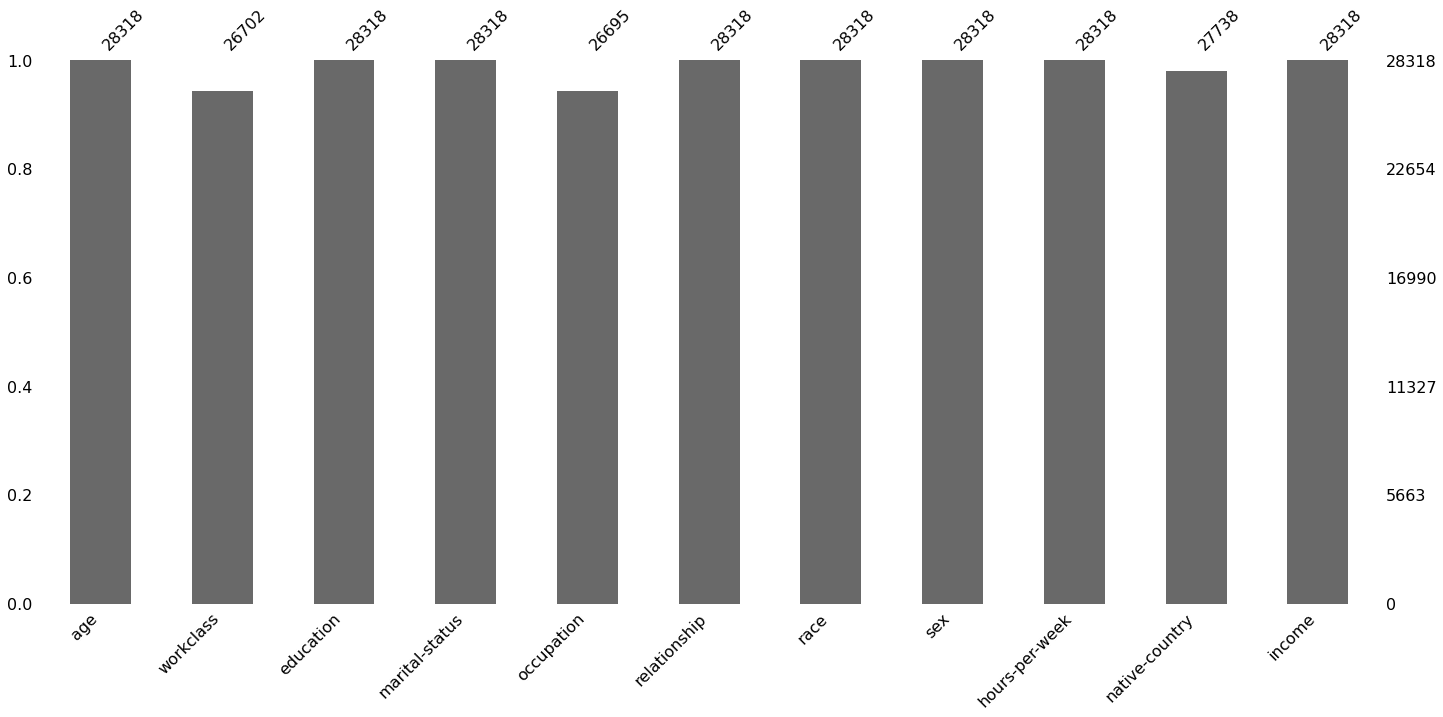

In [9]:
#visualiza a quantidade de registros nulos por atributo
msno.bar(data)

In [10]:
#total de registros nulos por atributo. 
data.isnull().sum()

age                  0
workclass         1616
education            0
marital-status       0
occupation        1623
relationship         0
race                 0
sex                  0
hours-per-week       0
native-country     580
income               0
dtype: int64

### Feature Engineering

#### Tratando dados faltantes
 - optaremos por três abordagens para o tratamento dos dados faltantes, visto que todos eles são categoricos.
 1. remoção dos registros que possuam pelo menos um dado faltante.
 2. preencher os dados faltantes pelo mais frequente na amostra (moda)
 3. preencher os dados faltantes por meio de um modelo de classificação (RandomForest ou LogistcRegression)
 
 - as abordagens 2 e 3 foram consideradas, uma vez que somente menos que 1% (30162/32561) da amostra possui dados faltantes.
 - para efeito de classificação, será considerada a abordagem que resultar no melhor desempenho dos modelos utilizados

In [11]:
#dropnulls | most_frequent | 
lang = "dropnulls"

match lang:
    case "dropnulls":
        data.dropna(axis=0, inplace=True)
        data.isnull().sum()
        print("nulos apagados")

    case "most_frequent":
        impute_mode = SimpleImputer(strategy = 'most_frequent')
        impute_mode.fit(data[['workclass', 'occupation','native-country']])
        data[['workclass', 'occupation','native-country']] = impute_mode.transform(df[['workclass', 'occupation','native-country']])
        print("nulos preenchidos com os registros mais frequentes")

    case _:
        # To perform KNN imputation, we need to normalize the input data and perform One Hot Encoding to categorical variables
        #from sklearn.impute import KNNImputer
        #imputer = KNNImputer(n_neighbors = 3)
        #df = pd.DataFrame(imputer.fit_transform(df),columns = df.columns)
        #X = df.drop("workclass", axis=1).values
        #Y = df["workclass"].values
        #X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)
        #forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, max_features=0.6, min_samples_leaf=3, n_jobs=-1)
        #forest.fit(X_train, Y_train)
        print("nenhuma das opções válidas")

nulos apagados


<AxesSubplot:>

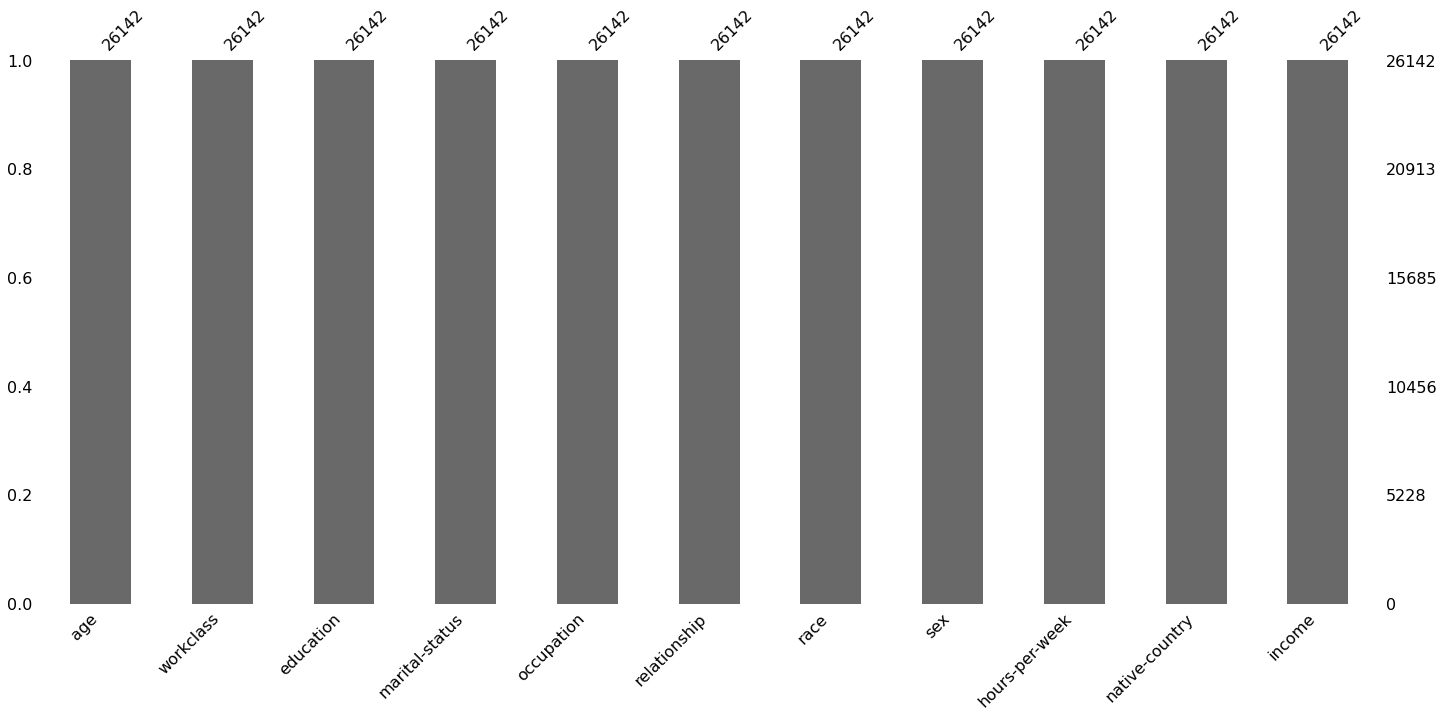

In [12]:
msno.bar(data)

#### Reestruturando atributos

In [13]:
data['fromUS'] = (data['native-country'] == 'United-States').astype(int)
data = data.drop('native-country', axis=1)

In [14]:
# Armazena os atributos categóricos dentre os atributos preditores
cat_col=[]
for i in data.columns:
    if data[i].dtype=='object':
        cat_col.append(i)
cat_col

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex']

In [15]:
# Armazena os atributos numéricos dentre os atributos preditores
num_col=[]
for colname, column_series in data._get_numeric_data().iteritems():
    num_col.append(colname)
num_col    

['age', 'hours-per-week', 'income', 'fromUS']

#### Registros de classificação impossível

In [22]:
all_columns = data.columns.tolist()
predictor_columns = list(set(all_columns).difference([target_column]))
column_frequency = (data
    .groupby(predictor_columns, as_index=False)
    .agg({target_column: 'nunique'}))

column_frequency[column_frequency.income > 1].shape[0]

0

In [23]:
#exemplo de um dos registros de treino impossível de classificar
impossible = data[(data['sex']=='Female') & (data['education']=='Assoc-acdm') & (data['workclass']=='Private') \
         & (data['marital-status']=='Divorced') & (data['occupation']=='Exec-managerial') \
         & (data['hours-per-week']==40)& (data['age']==40)& (data['marital-status']=='Divorced') ]
impossible

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,income,fromUS


In [24]:
data = data.drop_duplicates(subset=predictor_columns, keep=False)

In [25]:
data.shape

(24524, 11)

#### Encoding

In [40]:
def get_categorical_columns(data, cat_columns=None, fillna=True):
    if cat_columns is None:
        cat_data = data.select_dtypes('category')
    else:
        cat_data = data[cat_columns]

    if fillna:
        for colname, series in cat_data.iteritems():
            if 'Other' not in series.cat.categories:
                series = series.cat.add_categories(['Other'])

            cat_data[colname] = series.fillna('Other')
            
    return cat_data

def features_with_one_hot_encoded_categories(data, cat_columns=None, fillna=True):
    #cat_data = get_categorical_columns(data, cat_columns, fillna)
    cat_data = cat_col
    one_hot_data = pd.get_dummies(cat_data)
    df = pd.concat([data, one_hot_data], axis=1)

    features = [
        'age',
        #'education_num',
        'hours-per-week',
        #'capital_gain',
        #'capital_loss',
    ] + one_hot_data.columns.tolist()

    X = df[features].fillna(0).values.astype(float)
    y = df[target_column].values
    
    return X, y

In [47]:
one_hot_data = pd.get_dummies(cat_col)
#one_hot_data
df = pd.concat([data, one_hot_data], axis=1)
df.tail()

,age,workclass,education,marital-status,occupation,relationship,race,sex,hours-per-week,income,fromUS,education,marital-status,occupation,race,relationship,sex,workclass
32554,53.0,Private,Masters,Married-civ-spouse,Exec-managerial,Husband,White,Male,40.0,0.22847,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32555,22.0,Private,Some-college,Never-married,Protective-serv,Not-in-family,White,Male,40.0,0.00000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32556,27.0,Private,Assoc-acdm,Married-civ-spouse,Tech-support,Wife,White,Female,38.0,0.00000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32558,58.0,Private,HS-grad,Widowed,Adm-clerical,Unmarried,White,Female,40.0,0.00000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32560,52.0,Self-emp-inc,HS-grad,Married-civ-spouse,Exec-managerial,Wife,White,Female,40.0,0.22847,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
#X, y = features_with_one_hot_encoded_categories(data)
#validate_model(model, X, y)

### Treating outliers

In [32]:
# Function to detect outliers
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.25)
    quartile3 = dataframe[variable].quantile(0.75)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


## function to remove outliers
def replace_with_thresholds(dataframe, numeric_columns):
    for variable in numeric_columns:
        low_limit, up_limit = outlier_thresholds(dataframe, variable)
        dataframe.loc[(dataframe[variable] < low_limit), variable] = dataframe[variable].mean()
        dataframe.loc[(dataframe[variable] > up_limit), variable] = dataframe[variable].mean()

In [33]:
replace_with_thresholds(data,num_col)

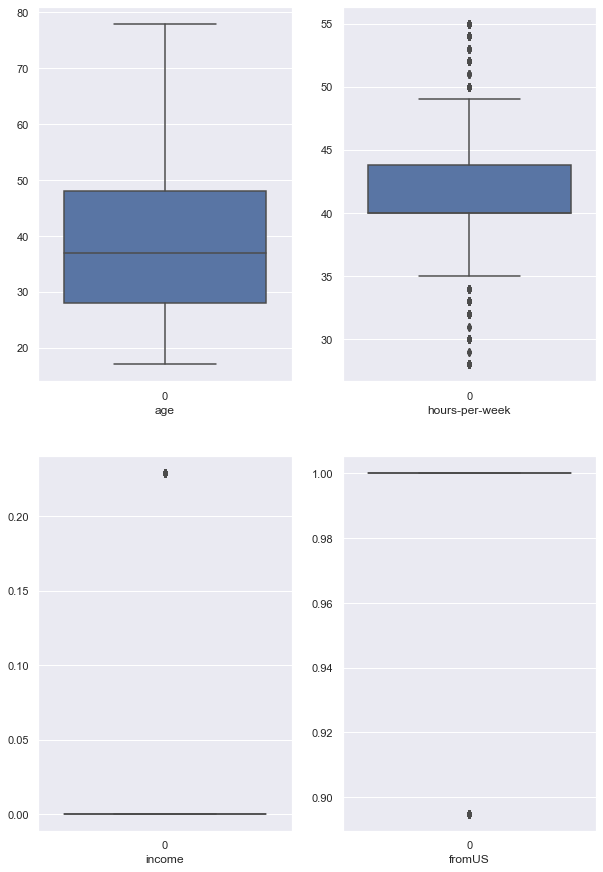

In [34]:
plt.figure(figsize=(10,40))
for i in range(0,len(num_col)):
    plt.subplot(5, 2, i+1)
    sns.boxplot(data=data[num_col[i]])
    plt.xlabel(num_col[i])

## Modelando os classificadores

creating a new copy of dataset(df) and convert it into numerical with the help of labelEncoder

In [ ]:
new_df = df.copy()
new_df.head()

In [ ]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
#data.drop('salary',axis=1,inplace=True)

from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)
data_categorical = data[categorical_columns]
data_categorical.head()


data_encoded = encoder.fit_transform(data_categorical)

a = pd.DataFrame(data_encoded,columns=['workclass', 'education', 'marital-status', 'occupation',
       'relationship', 'race', 'sex', 'country','salary'])
b = data[['age','hours-per-week']]
#c=data['hours-per-week']
new_df = pd.concat([b,a],axis=1)

In [ ]:
new_df

In [ ]:
new_df.shape

Dependent and Independent features

In [ ]:
X = new_df.iloc[:,:-1]
y = new_df.iloc[:,-1]

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=7,test_size=0.33)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

SVC

In [ ]:
svc = SVC().fit(X_train,y_train)

In [ ]:
svc.score(X_train,y_train)

In [ ]:
svc_pred = svc.predict(X_test)
accuracy_score(y_test,svc_pred)

Hyperparameter Tunning

In [ ]:
params = dict(kernel=['linear', 'poly'],C=[1,0.1,0.01])
Grid_model = GridSearchCV(svc,params,n_jobs=-1)
Grid_model.fit(X_train,y_train)
Grid_model.best_params_

In [ ]:
best_model = SVC(kernel='poly',gamma='scale',C=1).fit(X_train,y_train)

In [ ]:
best_model.score(X_train,y_train)

In [ ]:
best_pred = best_model.predict(X_test)

In [ ]:
accuracy_score(y_test,best_pred)